# Settings

In [1]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep
print(sep_local)

env: TF_KERAS=1
\


In [2]:
print(os.getcwd())

C:\Users\Khalid\Documents\projects\Generative_Models\notebooks\Super_Resolution\Progressive\ellwlb_total_variation\CBSD68


In [3]:
import sys
os.chdir('..' + sep_local +'..' + sep_local +'..' + sep_local + '..' + sep_local + '..' + sep_local + '..') # For Linux import
print(os.getcwd())

C:\Users\Khalid\Documents\projects\Generative_Models


In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


# Dataset loading

In [5]:
dataset_name='CBSD68'

In [6]:
images_dir =  '.' + sep_local + 'data' + sep_local + '.CBSD68'
validation_percentage = 10
valid_format = 'png'

In [7]:
images_dir

'.\\data\\.CBSD68'

In [8]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [9]:
imgs_list = create_image_lists(
    image_dir=images_dir, 
    validation_pct=validation_percentage, 
    valid_imgae_formats=valid_format
)

  DEBUG    | Looking for images in 'original'


  INFO     | 68 file found


In [10]:
from PIL import Image
trace_image = Image.open(images_dir+sep_local+'original'+sep_local+'{:04d}.png'.format(66))

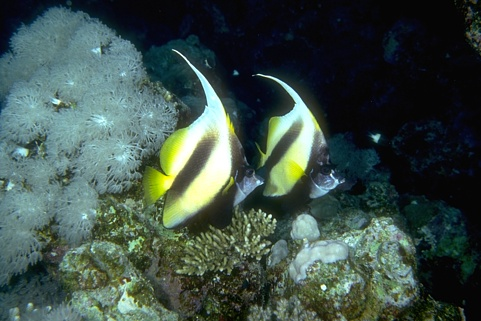

In [11]:
trace_image

In [12]:
image_size_original=(481, 321, 3)
scale = 2
image_size = list(map(lambda x: x//scale , image_size_original[:-1])) + [image_size_original[-1]]
image_size = (*image_size,)
batch_size = 16
latents_dim = 150
intermediate_dim = 50

In [13]:
image_size

(240, 160, 3)

In [14]:
training_generator, testing_generator = get_generators(
    images_list=imgs_list, 
    image_dir=images_dir, 
    image_size=image_size, 
    batch_size=batch_size, 
    class_mode=None
)

  INFO     | Found 59 training files


  INFO     | Found 9 validation files


## input is half of the output

In [15]:
inputs_shape = list(map(lambda x: x//2 , image_size[:-1])) + [image_size[-1]]
inputs_shape = (*inputs_shape, )

In [16]:
image_size, inputs_shape

((240, 160, 3), (120, 80, 3))

In [17]:
shrink_fn = lambda image: tf.image.resize(image, inputs_shape[:-1])
enlarge_fn = lambda image: tf.image.resize(image, image_size[:-1])

In [18]:
def generator_reshaper(generator): 
    while True:
        batch = next(generator)
        yield shrink_fn(batch), batch


In [19]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator_reshaper(training_generator), 
    output_types= (tf.float32, tf.float32),
    output_shapes=(tf.TensorShape((batch_size, ) +  inputs_shape), tf.TensorShape((batch_size, ) + image_size)),
)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator_reshaper(testing_generator), 
    output_types= (tf.float32, tf.float32),
    output_shapes=(tf.TensorShape((batch_size, ) +  inputs_shape), tf.TensorShape((batch_size, ) + image_size)),
)



In [20]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data[0].numpy().max())
    break

In [21]:
_instance_scale

1.0

In [22]:
import numpy as np
from collections.abc import Iterable
if isinstance(image_size, Iterable):
    _outputs_shape = np.prod(image_size)
_outputs_shape    

115200

# Model's Layers definition

In [23]:
kernel_size=3
stride = 2

In [24]:
c = list(map(lambda x: x// (stride*stride), image_size[:-1]))
c = (*c, intermediate_dim)
c

(60, 40, 50)

In [25]:
enc_lays = [

    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latents_dim)
]

dec_lays = [
    tf.keras.layers.Dense(units=np.product(c), activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=c),
    
    tf.keras.layers.Conv2D(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    tf.keras.layers.UpSampling2D(size=(2, 2)),

    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=kernel_size, strides=(1, 1), padding="SAME")
]

# Model definition

In [26]:
model_name = dataset_name+'_Conv_Progressive_Upsampling_ssim'
#windows
#experiments_dir='..' + sep_local + '..' + sep_local +'..' + sep_local + '..' + sep_local + '..'+sep_local+'experiments'+sep_local + model_name

#linux 
experiments_dir=os.getcwd()+ sep_local  +'experiments'+sep_local + model_name

In [27]:
variables_params = \
[
    {
        'name': 'inference',  #'constructive',
        'inputs_shape':inputs_shape,
        'outputs_shape':latents_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', #'upsampler', 
        'inputs_shape':latents_dim,
        'outputs_shape':image_size,
        'layers':dec_lays
    }
]

In [28]:
from os.path import abspath
from utils.data_and_files.file_utils import create_if_not_exist
_restore = os.path.join(experiments_dir, 'var_save_dir')
create_if_not_exist(_restore)
absolute = abspath(_restore)
print("Restore_dir",absolute)
absolute = abspath(experiments_dir)
print("Recording_dir",absolute)
print("Current working dir",os.getcwd())

Restore_dir C:\Users\Khalid\Documents\projects\Generative_Models\experiments\CBSD68_Conv_Progressive_Upsampling\var_save_dir
Recording_dir C:\Users\Khalid\Documents\projects\Generative_Models\experiments\CBSD68_Conv_Progressive_Upsampling
Current working dir C:\Users\Khalid\Documents\projects\Generative_Models


In [29]:
from training.autoencoding_basic.transformative.AE import autoencoder as AE

In [30]:
ae = AE( 
    name=model_name,
    latents_dim=latents_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=None,#to restore trained model, set filepath=_restore
    episode_len=1
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 120, 80, 3)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               4320150   
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
activity_regularization (Act (None, 150)               0         
_________________________________________________________________
inference_outputs (Activatio (None, 150)               0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generative_inputs (InputLaye [(None, 150)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120000)            18120000  
_________________________________________________________________
reshape (Reshape)            (None, 60, 40, 50)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 20, 50)        22550     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 60, 40, 50)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 120, 80, 50)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 40, 50)        2

  WARNING  | None


In [31]:
image_size, inputs_shape

((240, 160, 3), (120, 80, 3))

In [35]:
from evaluation.quantitive_metrics.structural_similarity import prepare_ssim_multiscale
from evaluation.quantitive_metrics.peak_signal_to_noise_ratio import prepare_psnr
from evaluation.quantitive_metrics.total_variation import prepare_total_variation
from statistical.losses_utilities import similarity_to_distance
from statistical.ae_losses import expected_loglikelihood_with_lower_bound as ellwlb

In [36]:
outputs_flat_shape = [ae.batch_size]+ae.get_outputs_shape()
psnr = similarity_to_distance(prepare_psnr(outputs_flat_shape))
ssim = similarity_to_distance(prepare_ssim_multiscale(outputs_flat_shape))
total_variation = prepare_psnr(outputs_flat_shape)

In [38]:
loss= lambda x_true, x_logits: ssim(x_true, x_logits)

In [39]:

ae.compile(loss={'x_logits': loss})

Model: "CBSD68_Conv_Progressive_Upsampling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 120, 80, 3)]      0         
_________________________________________________________________
inference (Model)            (None, 150)               4320750   
_________________________________________________________________
generative (Model)           (None, 240, 160, 3)       18189015  
_________________________________________________________________
tf_op_layer_x_logits (Tensor [(None, 240, 160, 3)]     0         
Total params: 22,509,765
Trainable params: 22,509,459
Non-trainable params: 306
_________________________________________________________________
None


# Callbacks

In [ ]:
# added for linux warning suppression
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)


from training.callbacks.trace_image_reconstruction import trace_reconstruction
from training.callbacks.save_model import ModelSaver

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=12, 
    verbose=1, 
    restore_best_weights=False
)

In [ ]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [ ]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, model_name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
absolute = abspath(csv_dir)
print("Csv_dir",absolute)

In [ ]:
image_reconstuction_dir = os.path.join(experiments_dir, 'image_reconstuction_dir')
create_if_not_exist(image_reconstuction_dir)
absolute = abspath(image_reconstuction_dir)
print("image_reconstuction_dir",absolute)

In [ ]:
image = shrink_fn(np.asarray(trace_image)).numpy()/255.0
img_reconst = trace_reconstruction(filepath=image_reconstuction_dir, image=image, gen_freq=5)

# Model Training

In [ ]:
ae.fit(
    x=train_ds,
    input_kw=None,
    steps_per_epoch=int(1e4),
    epochs=int(1e6), 
    verbose=2,
    callbacks=[ es, ms, csv_log, img_reconst],
    workers=-1,
    use_multiprocessing=True,
    validation_data=test_ds,
    validation_steps=1000
)